In [73]:
import torch, torch_pca, gc
from torchvision import datasets, transforms
import numpy as np, matplotlib.pyplot as plt, seaborn as sns, sklearn as sk
from PIL import Image


In [23]:
train_dataset = datasets.Imagenette(size="320px", root='data', split='train')
test_dataset = datasets.Imagenette(size="320px", root='data', split='val')

In [ ]:
def channel_pca(channel_index: int, n_components: int, side_length: int = 128, dtype=torch.float16):
    global train_dataset
    data = torch.empty(len(train_dataset), side_length, side_length, dtype=dtype)
    for (i, d) in enumerate(train_dataset):
        data[i, :, :] = torch.tensor(np.array(d[0])[0:side_length, 0:side_length, channel_index].reshape(side_length, side_length))
    data = data.reshape(-1, side_length*side_length)
    gc.collect()

    pca = torch_pca.PCA(n_components=n_components, svd_solver='randomized')
    pca.fit(data)
    gc.collect()
    return pca

In [ ]:
# May take a couple of minutes, depending on parameters
pcas = [channel_pca(channel, 100, 160) for channel in range(3)]

In [69]:
def pca_project(pcas, idx: int):
    global test_dataset
    sl = int(np.sqrt(pcas[0].n_features_in_))
    img = torch.tensor(np.array(test_dataset[idx][0])[0:sl, 0:sl, :], dtype=torch.float32)
    tchs = [pca.inverse_transform(pca.transform(img[:, :, ch].reshape(1, -1))).reshape(sl, sl, 1) for (ch, pca) in enumerate(pcas)]
    return torch.cat(tchs, dim=2)

In [102]:
def showimg(t):
    return Image.fromarray(torch.clamp(t, 0, 255).byte().numpy())

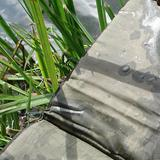

In [105]:
Image.fromarray(np.array(test_dataset[0][0])[0:160, 0:160])

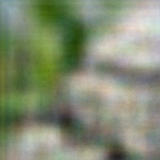

In [106]:
showimg(pca_project(pcas, 0))